In [1]:
from __future__ import annotations

import re
import os

from dataclasses import dataclass, field
from pathlib import Path
from typing import Dict, Any

import matplotlib.pyplot as plt
import numpy as np

from scipy.io import loadmat
from scipy.signal import butter, filtfilt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats("png")

import plots


DATASET_PATH = os.path.expanduser('~/data/BCI/1_EEG_LRhandMI')
DATASET_PATH

# rebase
# squash

'/Users/anna/data/BCI/1_EEG_LRhandMI'

In [ ]:
def filter_band(X, sampling_rate, lo=8.0, hi=30.0, order=4):
    """
    X: (n_trials, n_channels, n_samples)
    Returns band-passed X with same shape (float64 from filtfilt).
    """
    b, a = butter(order, [lo, hi], btype="bandpass", fs=sampling_rate)
    return filtfilt(b, a, X, axis=-1)


@dataclass
class SubjectData:
    subject_id: int
    sampling_rate: int
    n_trials: int
    n_samples: int
    X_left_raw: np.ndarray   # (n_trials, N_EEG_CHANNELS, n_samples)
    X_right_raw: np.ndarray  # (n_trials, N_EEG_CHANNELS, n_samples)
    electrode_locations: np.ndarray

    X: np.ndarray = field(init=False)
    Y: np.ndarray = field(init=False)

    def __post_init__(self):
        if self.X_left_raw.shape != self.X_right_raw.shape:
            raise ValueError(
                "X_left_raw and X_right_raw must have identical shapes, "
                f"got {self.X_left_raw.shape} vs {self.X_right_raw.shape}"
            )
        if self.X_left_raw.shape[0] != self.n_trials:
            raise ValueError(
                f"n_trials={self.n_trials}, but X_left_raw has "
                f"{self.X_left_raw.shape[0]} trials"
            )
        self.X = filter_band(
            np.concatenate([self.X_left_raw, self.X_right_raw], axis=0),
            sampling_rate=self.sampling_rate,
        )
        self.Y = np.concatenate([
            np.zeros(self.n_trials, dtype=np.int8),
            np.ones(self.n_trials, dtype=np.int8),
        ], axis=0)

    def print_info(self):
        print(f'Subject ID: {self.subject_id}')
        print(f'sampling_rate: {self.sampling_rate}, n_samples: {self.n_samples}, n_trials: {self.n_trials}')
        print(f'X_left_raw: {self.X_left_raw.shape}')
        print(f'X_right_raw: {self.X_right_raw.shape}')
        print(f'X: {self.X.shape}, Y: {self.Y.shape}')

    def plot_head(self, trial: int, index=None, timestamp=None):
        if trial < 0 or trial >= self.n_trials:
            raise IndexError(f"`trial` out of range: {trial} (valid: 0..{self.n_trials-1})")
        if index is not None and timestamp is not None:
            raise ValueError("Specify either `index` or `timestamp`.")
        elif index is None and timestamp is None:
            index = 0
        elif timestamp is not None:
            index = int(round(float(timestamp) * self.sampling_rate))
        if index < 0 or index >= self.n_samples:
            raise IndexError(f"`index` out of range: {index} (valid: 0..{self.n_samples-1})")

        electrode_locations = np.asarray(self.electrode_locations, dtype=float)
        if electrode_locations.shape[0] != self.X.shape[1] or electrode_locations.shape[1] < 2:
            raise ValueError(f"electrode_locations shape {electrode_locations.shape} incompatible with channels {self.X.shape[1]}")
        t = index / self.sampling_rate
        title = f'Subject {self.subject_id}. Trial {trial}. Timestamp {t:.2f}s.'
        plots.plot_scalp(
            signal=self.X[trial, :, index],
            channel_locations=electrode_locations[:, :2],
            title=title + ' LEFT'
        )
        plots.plot_scalp(
            signal=self.X[trial + self.n_trials, :, index],
            channel_locations=electrode_locations[:, :2],
            title=title + ' RIGHT'
        )

    def plot_channel(self, trial: int, channel: int, index=None, timestamp=None):
        if trial < 0 or trial >= self.n_trials:
            raise IndexError(f"`trial` out of range: {trial} (valid: 0..{self.n_trials-1})")
        n_channels = self.X.shape[1]
        if channel < 0 or channel >= n_channels:
            raise IndexError(f"`channel` out of range: {channel} (valid: 0..{n_channels-1})")
        if index is not None and timestamp is not None:
            raise ValueError("Specify either `index` or `timestamp`.")
        elif index is None and timestamp is None:
            index = 0
        elif timestamp is not None:
            index = int(round(float(timestamp) * self.sampling_rate))
        if index < 0 or index >= self.n_samples:
            raise IndexError(f"`index` out of range: {index} (valid: 0..{self.n_samples-1})")

        title = f"Subject {self.subject_id}. Trial {trial}. Channel {channel}."
        left_trace = self.X[trial, channel, index:]
        right_trace = self.X[trial + self.n_trials, channel, index:]
        t = np.arange(left_trace.shape[0], dtype=float) / float(self.sampling_rate)
        plots.plot_eeg_channel_lr(t, left_trace, right_trace, title=title)

    def plot_trial(self, trial: int, channel_indices=None, side="left"):
        if trial < 0 or trial >= self.n_trials:
            raise IndexError(f"`trial` out of range: {trial} (valid: 0..{self.n_trials-1})")
        if side not in ("left", "right"):
            raise ValueError(f"`side` must be 'left' or 'right'; got {side!r}")

        t = np.arange(self.n_samples, dtype=float) / self.sampling_rate
        sample = self.X[trial, :, :] if side == "left" else self.X[trial + self.n_trials, :, :]
        title = f"Subject {self.subject_id}. Trial {trial}. {side.upper()}"
        plots.plot_eeg_heatmap(t, sample, title=title)


class Dataset:
    _FNAME_RE = re.compile(r"^s(\d+)\.mat$")

    # Paper window for classification: 0.5–2.5 seconds after onset
    T_START = 0.5
    T_END = 2.5

    # EEG channels 1–64 (65–68 are EMG)
    N_EEG_CHANNELS = 64

    def __init__(self, dataset_path):
        self.dataset_path = Path(dataset_path)
        self.subject_data = self._load_subject_data()

    def get_subject(self, sid: int):
        if sid in self.subject_data:
            return self.subject_data[sid]
        raise KeyError(f'Subject {sid} not found.')

    def _load_subject_data(self):
        if not self.dataset_path.is_dir():
            raise ValueError(f"Could not find directory `{self.dataset_path}`")

        matches = []
        for p in self.dataset_path.iterdir():
            if p.is_file():
                m = self._FNAME_RE.match(p.name)
                if m:
                    matches.append((int(m.group(1)), p))
        if not matches:
            raise ValueError(f"No subject files like `s#.mat` found in `{self.dataset_path}`")

        subject_data = {}
        for subject_id, p in matches:
            mat = loadmat(p, simplify_cells=True)
            if "eeg" not in mat:
                raise ValueError(f"`{p.name}` missing key 'eeg'")
            eeg = mat["eeg"]
            srate = int(eeg["srate"])
            n_trials = int(eeg["n_imagery_trials"])
            onsets = np.where(eeg["imagery_event"] == 1)[0]
            if len(onsets) < n_trials:
                raise ValueError(f"`{p.name}`: found {len(onsets)} imagery onsets, expected at least {n_trials}")

            start = int(round(self.T_START * srate))
            end = int(round(self.T_END * srate))
            win = end - start
            if win <= 0:
                raise ValueError("T_END must be > T_START")

            left_stream = np.asarray(eeg["imagery_left"])[: self.N_EEG_CHANNELS, :]
            right_stream = np.asarray(eeg["imagery_right"])[: self.N_EEG_CHANNELS, :]
            X_left = np.empty(
                (n_trials, self.N_EEG_CHANNELS, win),
                dtype=left_stream.dtype
            )
            X_right = np.empty(
                (n_trials, self.N_EEG_CHANNELS, win),
                dtype=right_stream.dtype
            )
            stream_len = left_stream.shape[1]
            for i, onset in enumerate(onsets[:n_trials]):
                a = onset + start
                b = onset + end
                if a < 0 or b > stream_len:
                    raise ValueError(
                        f"`{p.name}`: trial {i} window [{a}:{b}] out of bounds "
                        f"for stream length {stream_len}"
                    )
                X_left[i] = left_stream[:, a:b]
                X_right[i] = right_stream[:, a:b]

            subject_data[subject_id] = SubjectData(
                subject_id=subject_id,
                sampling_rate=srate,
                n_trials=n_trials,
                n_samples=win,
                X_left_raw=X_left,
                X_right_raw=X_right,
                electrode_locations=np.asarray(eeg["psenloc"])[: self.N_EEG_CHANNELS, :]
            )

        return subject_data

    def print_info(self):
        total_bytes = sum(
            (s.X_left_raw.nbytes + s.X_right_raw.nbytes)
            for s in self.subject_data.values()
        )
        print(f"Total subjects: {len(self.subject_data)}")
        print(f"Epoch window: {self.T_START:.3f}–{self.T_END:.3f} s")
        print(f"Channels stored: {self.N_EEG_CHANNELS}")
        print(f"Total subject data (trial tensors only): {total_bytes / 1024**2:.2f} MB")
        for subject in self.subject_data.values():
            print()
            subject.print_info()

    def subject_ids(self):
        return np.array(sorted(self.subject_data.keys()))

    def get_XY(self, subject_id=None):
        subject_ids = self.subject_ids()
        if subject_id is not None:
            if subject_id not in subject_ids:
                raise KeyError(f"Subject {subject_id} not found. Available: {subject_ids}")
            subject_ids = np.array([subject_id])

        X_parts, y_parts, g_parts = [], [], []
        for sid in subject_ids:
            subject = self.subject_data[sid]
            X_parts.append(subject.X)
            y_parts.append(subject.Y)
            g_parts.append(np.full(subject.X.shape[0], subject.subject_id, dtype=np.int16))
        X = np.concatenate(X_parts, axis=0)
        y = np.concatenate(y_parts, axis=0)
        groups = np.concatenate(g_parts, axis=0)
        return X, y, groups

In [3]:
ds = Dataset(DATASET_PATH)

In [4]:
subject45 = ds.get_subject(45)
subject45.print_info()

Subject ID: 45
sampling_rate: 512, n_samples: 1024, n_trials: 100
X_left_raw: (100, 64, 1024)
X_right_raw: (100, 64, 1024)
X: (200, 64, 1024), Y: (200,)


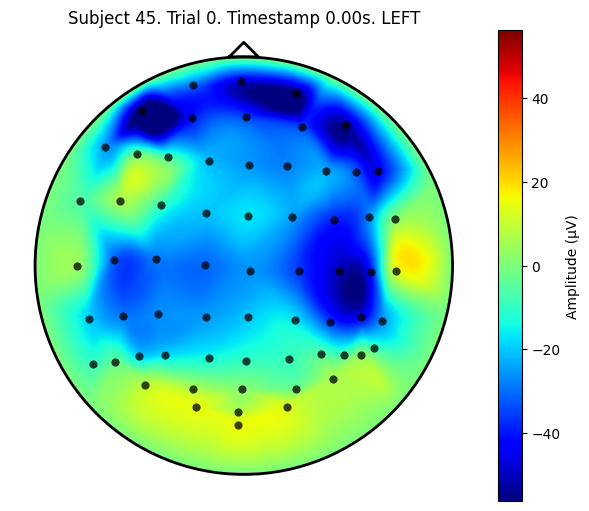

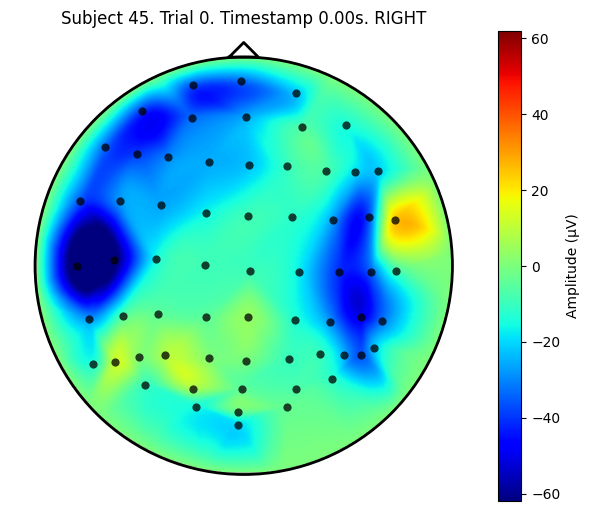

In [5]:
subject45.plot_head(trial=0)

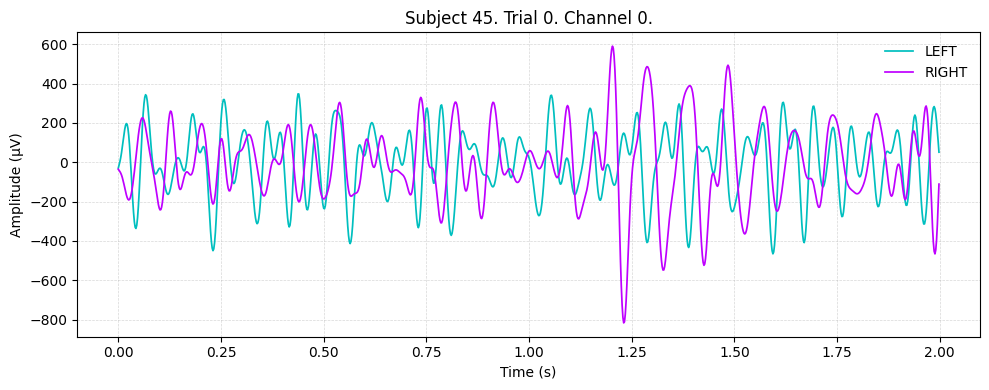

In [6]:
subject45.plot_channel(trial=0, channel=0)

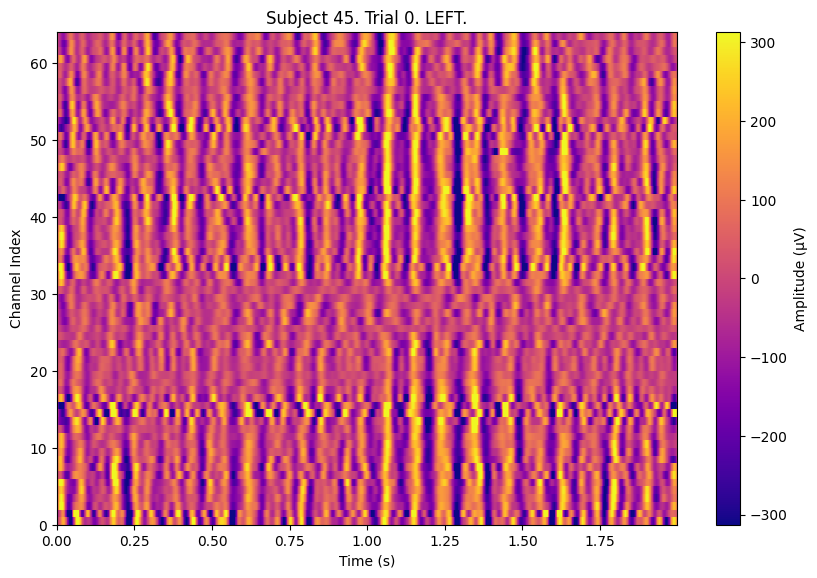

In [7]:
subject45.plot_trial(trial=0)

In [7]:
X, Y, groups = ds.get_XY()
X.shape, Y.shape, groups.shape

((3640, 64, 1024), (3640,), (3640,))

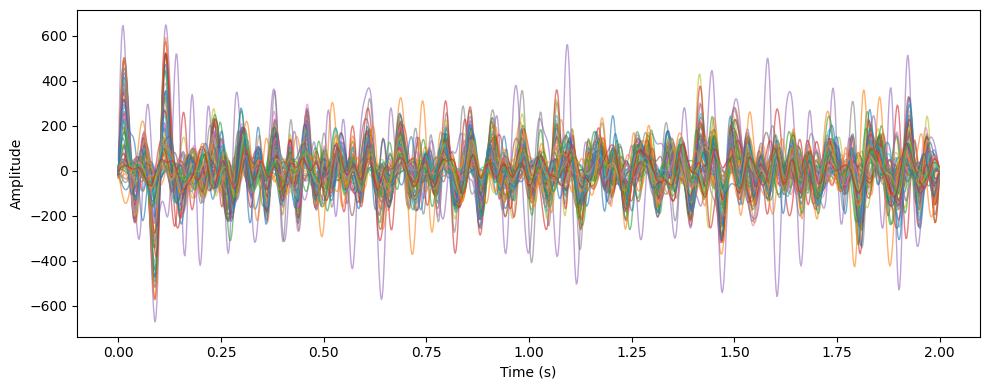

In [ ]:
def plot_sample(sample, fs=512, alpha=0.6, linewidth=1.0, title=None):
    """
    Plot all channels of one EEG sample on the same axes.

    sample : np.ndarray
        Shape (n_channels, n_samples)
    fs : int
        Sampling rate (Hz)
    """
    import numpy as np
    import matplotlib.pyplot as plt

    if sample.ndim != 2:
        raise ValueError(f"Expected shape (channels, samples), got {sample.shape}")

    n_channels, n_samples = sample.shape
    t = np.arange(n_samples) / fs

    plt.figure(figsize=(10, 4))
    for ch in range(n_channels):
        plt.plot(t, sample[ch], alpha=alpha, linewidth=linewidth)

    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()

plot_sample(X[0])


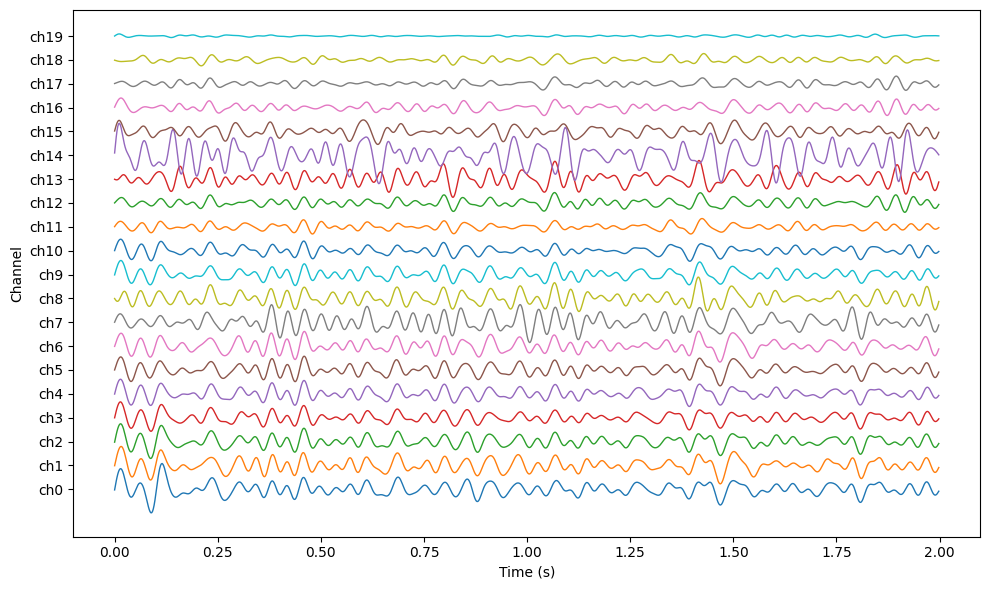

In [12]:
def plot_eeg_stacked(sample, fs=512, channels=None, max_channels=20, title=None):
    import numpy as np
    import matplotlib.pyplot as plt

    if channels is None:
        channels = list(range(min(max_channels, sample.shape[0])))

    t = np.arange(sample.shape[1]) / fs

    # robust offset so one crazy channel doesn't ruin spacing
    scale = np.median(np.std(sample[channels], axis=1))
    if not np.isfinite(scale) or scale == 0:
        scale = 1.0
    offset = 5.0 * scale

    plt.figure(figsize=(10, 6))
    for i, ch in enumerate(channels):
        plt.plot(t, sample[ch] + i * offset, linewidth=1)

    plt.yticks([i * offset for i in range(len(channels))],
               [f"ch{ch}" for ch in channels])
    plt.xlabel("Time (s)")
    plt.ylabel("Channel")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()

plot_eeg_stacked(X[0])

In [ ]:
def plot_sample(sample, fs=512, channels=None, max_channels=16, title=None):
    # Robust scaling for offsets (avoids single bad channel ruining plot)
    scale = np.median(np.std(sample[channels], axis=1))
    if not np.isfinite(scale) or scale == 0:
        scale = 1.0
    offset = 5.0 * scale

    plt.figure(figsize=(10, 4))
    for i, ch in enumerate(channels):
        plt.plot(t, sample[ch] + i * offset, linewidth=1)

    plt.yticks(
        [i * offset for i in range(len(channels))],
        [f"ch{ch}" for ch in channels],
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Channel")
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()


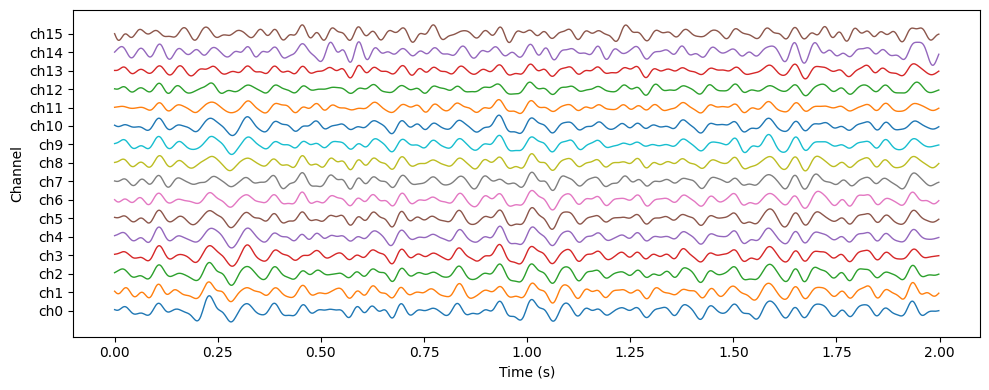

In [6]:
plot_sample(X[0])

In [ ]:
def compute_cov(sample):
    """sample: (n_channels, n_samples) -> normalized covariance (n_channels, n_channels)"""
    C = sample @ sample.T
    tr = np.trace(C)
    return C / tr if tr > 0 else C


def fit_csp(X_train, y_train, n_components=4, reg=1e-10):
    """
    Classic 2-class CSP.
    Returns spatial filters W of shape (n_channels, n_components).
    """
    classes = np.unique(y_train)
    if len(classes) != 2:
        raise ValueError("CSP requires exactly 2 classes.")

    c0, c1 = classes[0], classes[1]
    X0 = X_train[y_train == c0]
    X1 = X_train[y_train == c1]

    C0 = np.mean([compute_cov(x) for x in X0], axis=0)
    C1 = np.mean([compute_cov(x) for x in X1], axis=0)

    # Regularize slightly for stability
    n_ch = C0.shape[0]
    C0 = C0 + reg * np.eye(n_ch)
    C1 = C1 + reg * np.eye(n_ch)

    Cc = C0 + C1

    # Solve generalized eigenvalue problem: C0 w = λ (C0 + C1) w
    # Use standard eig on inv(Cc) @ C0
    evals, evecs = np.linalg.eig(np.linalg.solve(Cc, C0))
    evals = np.real(evals)
    evecs = np.real(evecs)

    # Sort by eigenvalue (most discriminative at extremes)
    idx = np.argsort(evals)
    evecs = evecs[:, idx]

    # Pick extremes: first k/2 and last k/2
    k2 = n_components // 2
    W = np.concatenate([evecs[:, :k2], evecs[:, -k2:]], axis=1)
    return W


def csp_logvar_features(X, W):
    """
    Project: Z = W^T X, then log-variance per component.
    X: (n_trials, n_channels, n_samples)
    W: (n_channels, n_components)
    Returns F: (n_trials, n_components)
    """
    Z = np.einsum("tcj,ck->tkj", X, W)  # (trials, comps, samples)
    var = np.var(Z, axis=-1, ddof=0)
    # normalize variance per trial (optional but common)
    var = var / (np.sum(var, axis=1, keepdims=True) + 1e-12)
    return np.log(var + 1e-12)


def eval_subject_csp_lda(X_subj, y_subj, fs, n_repeats=120, test_frac=0.30, seed=0):
    rng = np.random.default_rng(seed)
    n = len(y_subj)
    idx0 = np.where(y_subj == 0)[0]
    idx1 = np.where(y_subj == 1)[0]

    n_test0 = int(round(len(idx0) * test_frac))
    n_test1 = int(round(len(idx1) * test_frac))

    accs = []
    for _ in range(n_repeats):
        test0 = rng.choice(idx0, size=n_test0, replace=False)
        test1 = rng.choice(idx1, size=n_test1, replace=False)
        test_idx = np.concatenate([test0, test1])
        train_mask = np.ones(n, dtype=bool)
        train_mask[test_idx] = False
        train_idx = np.where(train_mask)[0]

        X_train, y_train = X_subj[train_idx], y_subj[train_idx]
        X_test, y_test = X_subj[test_idx], y_subj[test_idx]

        # CSP fit + features
        W = fit_csp(X_train, y_train, n_components=4)
        F_train = csp_logvar_features(X_train, W)
        F_test = csp_logvar_features(X_test, W)

        # LDA
        clf = LinearDiscriminantAnalysis()
        clf.fit(F_train, y_train)
        accs.append(clf.score(F_test, y_test))

    accs = np.array(accs, dtype=float)
    return float(accs.mean()), float(accs.std())


def evaluate_all_subjects(X, Y, groups, fs=512, n_repeats=120, test_frac=0.30, seed=0):
    subj_ids = np.unique(groups)
    results = {}
    for sid in subj_ids:
        mask = (groups == sid)
        Xs, ys = X[mask], Y[mask]
        mean_acc, std_acc = eval_subject_csp_lda(Xs, ys, fs=fs, n_repeats=n_repeats, test_frac=test_frac, seed=seed)
        results[int(sid)] = (mean_acc, std_acc)
        print(f"s{int(sid):02d}: {mean_acc*100:.2f}% ± {std_acc*100:.2f}%")

    all_means = np.array([v[0] for v in results.values()], dtype=float)
    print("\nOverall (mean across subjects): "
          f"{all_means.mean()*100:.2f}% ± {all_means.std()*100:.2f}% (std across subjects)")
    return results


In [18]:
results = evaluate_all_subjects(X, Y, groups, fs=512, n_repeats=120, test_frac=0.30, seed=42)

s36: 67.54% ± 7.21%

Overall (mean across subjects): 67.54% ± 0.00% (std across subjects)


In [3]:
s52_path = os.path.join(DATASET_PATH, 's52.mat')
mat = loadmat(s52_path, simplify_cells=True)
print([k for k in mat.keys() if not k.startswith("__")])

['eeg']


In [5]:
eeg = mat["eeg"]

print("eeg keys:", list(eeg.keys()))

for k, v in eeg.items():
    t = type(v).__name__
    shp = getattr(v, "shape", None)
    dt  = getattr(v, "dtype", None)
    # keep it readable
    if isinstance(v, (str, int, float, bool)):
        extra = f"value={v}"
    elif isinstance(v, (list, tuple)):
        extra = f"len={len(v)}"
    elif shp is not None:
        extra = f"shape={shp} dtype={dt}"
    else:
        extra = ""
    print(f"{k:20s} {t:15s} {extra}")


eeg keys: ['noise', 'rest', 'srate', 'movement_left', 'movement_right', 'movement_event', 'n_movement_trials', 'imagery_left', 'imagery_right', 'n_imagery_trials', 'frame', 'imagery_event', 'comment', 'subject', 'bad_trial_indices', 'psenloc', 'senloc']
noise                ndarray         shape=(5,) dtype=object
rest                 ndarray         shape=(68, 34048) dtype=float32
srate                int             value=512
movement_left        ndarray         shape=(68, 71680) dtype=float32
movement_right       ndarray         shape=(68, 71680) dtype=float32
movement_event       ndarray         shape=(71680,) dtype=uint8
n_movement_trials    int             value=20
imagery_left         ndarray         shape=(68, 358400) dtype=float32
imagery_right        ndarray         shape=(68, 358400) dtype=float32
n_imagery_trials     int             value=100
frame                ndarray         shape=(2,) dtype=int16
imagery_event        ndarray         shape=(358400,) dtype=uint8
comment  

In [8]:
events = eeg["imagery_event"]
onsets = np.where(events == 1)[0]
len(onsets) 

100

In [ ]:
fs = eeg["srate"]

t_end

1536

In [10]:
X_left_raw = []
for idx in onsets[:eeg["n_imagery_trials"]]:
    trial = eeg["imagery_left"][:, idx + t_start : idx + t_end]
    X_left_raw.append(trial)

X_left_raw = np.stack(X_left_raw)
X_left_raw.shape

(100, 68, 1536)